# 等离子体电子声波：Two-kappa Electrons Model

In [1]:
import numpy as np
from prettytable import PrettyTable
import os
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal
import scipy.optimize as op
import plasmapy
from scipy import special as sp
from scipy import integrate
from prettytable import PrettyTable
from scipy import fftpack
from tqdm import tqdm
%config InlineBackend.figure_format = 'svg'

In [2]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth': 2})

## 模型
### 1D等离子体：双kappa运动电子+静止均匀分布离子
- 初始分布函数
$$ f(x,v,0) = \left( f_s + f_f  \right) (1+d \cos kx) $$
$$ f_s = \frac{n_s}{\sqrt{2\pi T (\kappa_s-3/2)}} \frac{\Gamma(\kappa_s)}{\Gamma(\kappa_s-1/2)} \left( 1+\frac{1}{\kappa_s-3/2} \frac{v^2}{2T} \right)^{-\kappa_s} $$
$$ f_f = \frac{n_f}{\sqrt{2\pi T (\kappa_f-3/2)}} \frac{\Gamma(\kappa_f)}{\Gamma(\kappa_f-1/2)} \left( 1+\frac{1}{\kappa_f-3/2} \frac{v^2}{2T} \right)^{-\kappa_f} $$
                          
- 色散关系
$$ 1 + \frac{2 \omega_s^2}{k^2 \theta_s^2} \left[ 1 - \frac{1}{2\kappa_s} +\xi_s Z_{\kappa_s}(\xi_s) \right] + \frac{2 \omega_f^2}{k^2 \theta_f^2} \left[ 1 - \frac{1}{2 \kappa_f} +\xi_f Z_{\kappa_f}(\xi_f) \right] = 0 $$
其中$\xi_\sigma = \frac{\omega}{k \theta_\sigma}$，$\theta_\sigma = \sqrt{\frac{2\kappa_\sigma-3}{\kappa_\sigma} \frac{T}{m}}$，
$$ Z_{\kappa_\sigma}(\xi) = \frac{\Gamma(\kappa_\sigma+1)}{\sqrt{\pi}\kappa_\sigma^{3/2} \Gamma(\kappa_\sigma-1/2)} \int_{-\infty}^{+\infty} \frac{(1+s^2/\kappa_\sigma)^{-\kappa_\sigma-1}}{s-\xi} ds$$
上述色散关系将允许两支波，一支类似于fast electrons的Langmuir波（LW）；另一支类似于slow electrons的Acoustic波（KW，由两组分不同$\kappa$导致）

- 让KW展现出来的关键在于
    - 排除热电子LW，$\gamma_{KW} < \gamma_{LW}^{hot}$
    - KW本身不能过阻尼，$\gamma_{KW} \le \omega_r/(2\pi)$，满足此条件可获得存在较长时间的KW

## 数值理论分析

In [3]:
def fk(v):
    r_s = ( 1 + v**2/(kappa_s-3/2)/(2*T) )**(-kappa_s)
    r_f = ( 1 + v**2/(kappa_f-3/2)/(2*T) )**(-kappa_f)
    A_s = n_s/np.sqrt(2*np.pi*T*(kappa_s-3/2)) * sp.gamma(kappa_s)/sp.gamma(kappa_s-1/2)
    A_f = n_f/np.sqrt(2*np.pi*T*(kappa_f-3/2)) * sp.gamma(kappa_f)/sp.gamma(kappa_f-1/2)
    
    return A_s*r_s+A_f*r_f

# exact PDR
def dispersion_function(zeta,kappa):
    fac = 1j * (kappa+0.5) * (kappa-0.5) / kappa**1.5 / (kappa+1)
    z = 0.5*(1+1j*zeta/np.sqrt(kappa))
    hyp = sp.hyp2f1(1,2*kappa+2,kappa+2,z)
    return fac*hyp

def PDR_2KE(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_s = wc / k /v_s
    zeta_f = wc / k /v_f
    zs = 1 - 1/2/kappa_s + zeta_s*dispersion_function(zeta_s,kappa_s)
    if kappa_f == 0:
        zf = 1 + zeta_f*plasmapy.dispersion.plasma_dispersion_func(zeta_f)
    else:
        zf = 1 - 1/2/kappa_f + zeta_f*dispersion_function(zeta_f,kappa_f)
    r = 1 + (kappa_s/(kappa_s-1.5)) / k**2 / l_s**2 * zs + 1 / k**2 / l_f**2 * zf
    return [r.real,r.imag]

def PrintParas():
    paras_table = PrettyTable(['T='+str(T),'n','kappa','wp','theta','lambda_D'])
    paras_table.add_row(['s',n_s,kappa_s,round(wp_s,4),round(v_s,4),round(l_s,4)])
    paras_table.add_row(['f',n_f,'-',round(wp_f,4),round(v_f,4),round(l_f,4)])
    print(paras_table)
    
def SetParas():
    n_f = n-n_s
    l_s = np.sqrt( T / n_s / q**2 ) # $\lambda_D^2$
    l_f = np.sqrt( T / n_f / q**2 ) # $\lambda_D^2$
    wp_s = np.sqrt( n_s * q**2 )
    wp_f = np.sqrt( n_f * q**2 )
    v_s = np.sqrt((2-3/kappa_s)*T/m)
    if kappa_f == 0:
        v_f = np.sqrt(2*T/m)
    else:
        v_f = np.sqrt((2-3/kappa_f)*T/m)
    return n_f,l_s,l_f,wp_s,wp_f,v_s,v_f

### PDR中的KW分支和LW分支

In [4]:
# 等离子体基本参数
n = 1
q = 1
m = 1
T = 1

n_s = 0.75
kappa_s = 1.501
kappa_f = 20

n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
PrintParas()

+-----+------+-------+-------+--------+----------+
| T=1 |  n   | kappa |   wp  | theta  | lambda_D |
+-----+------+-------+-------+--------+----------+
|  s  | 0.75 | 1.501 | 0.866 | 0.0365 |  1.1547  |
|  f  | 0.25 |   -   |  0.5  | 1.3601 |   2.0    |
+-----+------+-------+-------+--------+----------+


In [5]:
wr_kw_guess = 0.0153
wi_kw_guess = -0.06
wr_lw_guess = 1.002
wi_lw_guess = 0.0

In [6]:
kls_list = np.linspace(0.1,4.0,num=800)
k_list = kls_list/l_s
# 搜索a=0时解方程初值
s0=op.root(lambda w:PDR_2KE(w,k_list[0]),[wr_kw_guess,wi_kw_guess],method='hybr')
s2=op.root(lambda w:PDR_2KE(w,k_list[0]),[wr_lw_guess,wi_lw_guess],method='hybr')
print('k = ',k_list[0])
print(s0.success,s0.x)
print(s2.success,s2.x)
wr_kw_guess_int = s0.x[0]
wi_kw_guess_int = s0.x[1]
wr_lw_guess_int = s2.x[0]
wi_lw_guess_int = s2.x[1]

k =  0.08660254037844388
True [ 0.07378441 -0.0649369 ]
True [ 9.93435817e-01 -2.66120991e-05]


In [7]:
wr_kw_guess = wr_kw_guess_int
wi_kw_guess = wi_kw_guess_int
wr_lw_guess = wr_lw_guess_int
wi_lw_guess = wi_lw_guess_int

wr_kw_list = np.array([])
wi_kw_list = np.array([])
wr_lw_list = np.array([])
wi_lw_list = np.array([])

for k_each in tqdm(k_list,position=0,leave=True):
    s_kw = op.root(lambda w:PDR_2KE(w,k_each),[wr_kw_guess,wi_kw_guess])
    if s_kw.success==True:
        wr_kw_guess = round(s_kw.x[0],10)
        wi_kw_guess = round(s_kw.x[1],10)
        wr_kw_list = np.append(wr_kw_list,s_kw.x[0])
        wi_kw_list = np.append(wi_kw_list,s_kw.x[1])
    else:
        wr_kw_list = np.append(wr_kw_list,np.nan)
        wi_kw_list = np.append(wi_kw_list,np.nan)
        
    s_lw = op.root(lambda w:PDR_2KE(w,k_each),[wr_lw_guess,wi_lw_guess],method='hybr')
    if s_lw.success==True:
        wr_lw_guess = round(s_lw.x[0],6)
        wi_lw_guess = round(s_lw.x[1],6)
        wr_lw_list = np.append(wr_lw_list,s_lw.x[0])
        wi_lw_list = np.append(wi_lw_list,s_lw.x[1])
    else:
        wr_lw_list = np.append(wr_lw_list,np.nan)
        wi_lw_list = np.append(wi_lw_list,np.nan)

100%|███████████████████████████████████████████████████████████████████████████████| 800/800 [00:01<00:00, 630.83it/s]


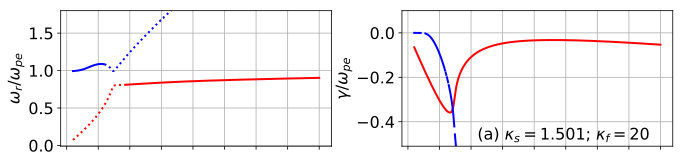

In [8]:
fig = plt.figure(figsize=(11,2.5))
x_ticks = np.linspace(0.0,4.0,num=9)

ax1 = plt.subplot(121)
# ax1.set_xlabel('$k \lambda_s$')
# plt.xticks(x_ticks)
plt.xticks(x_ticks,())

ax2 = plt.subplot(122)
# ax2.set_xlabel('$k \lambda_s$')
# plt.xticks(x_ticks)
plt.xticks(x_ticks,())

ax1.set_ylabel(r'$\omega_r/\omega_{pe}$')
ax2.set_ylabel(r'$\gamma/\omega_{pe}$')
ax1.grid()
ax2.grid()

b_kw = wi_kw_list/abs(wr_kw_list/2/np.pi)
b_lw = wi_lw_list/abs(wr_lw_list/2/np.pi)

# strongdamping_1 = kls_list[b_kw<=-1] <= kls_list[b_kw>-1][0]
# strongdamping_2 = kls_list[b_kw<=-1] >= kls_list[b_kw>-1][0]

# ax1.plot(kls_list[b_kw<-1][strongdamping_1],wr_kw_list[b_kw<-1][strongdamping_1],':',color='red')
# ax1.plot(kls_list[b_kw<-1][strongdamping_2],wr_kw_list[b_kw<-1][strongdamping_2],':',color='red')
ax1.plot(kls_list[b_kw<-1],wr_kw_list[b_kw<-1],':',color='red')
ax1.plot(kls_list[b_kw>-1],wr_kw_list[b_kw>-1],'-',color='red')

# weakdamping_1 = kls_list[b_lw>-1] <= kls_list[b_lw<=-1][0]
# weakdamping_2 = kls_list[b_lw>-1] >= kls_list[b_lw<=-1][0]

# ax1.plot(kls_list[b_lw>-1][weakdamping_1],wr_lw_list[b_lw>-1][weakdamping_1],'-',color='blue')
# ax1.plot(kls_list[b_lw>-1][weakdamping_2],wr_lw_list[b_lw>-1][weakdamping_2],'-',color='blue')
ax1.plot(kls_list[b_lw>-1],wr_lw_list[b_lw>-1],'-',color='blue')
ax1.plot(kls_list[b_lw<=-1],wr_lw_list[b_lw<=-1],':',color='blue')
# ax1.axvline(0.92)

ax1.set_ylim(-0.01,1.8)

ax2.plot(kls_list,wi_kw_list,color='red')
ax2.plot(kls_list,wi_lw_list,color='blue')
ax2.text(1.1,-0.48,r"(a) $\kappa_s = $"+str(kappa_s)+"; $\kappa_f = $"+str(kappa_f))
# ax2.text(1.15,-0.96,r"(c) $\kappa_s = $"+str(kappa_s)+"; $\kappa_f = \infty$")
# ax2.set_ylim(-1.02,0.1)
ax2.set_ylim(-0.51,0.1)

# plt.suptitle(r"$n_s = $"+str(n_s)+"; $T = $"+str(T),y=1.02)
plt.subplots_adjust(hspace = 0.01,wspace=0.26)
# plt.savefig('./figs/2a-existence.eps',dpi=600,bbox_inches = 'tight')
plt.show()

### KW波色散关系随$\kappa_s$变化规律

In [15]:
kappa_s_list = np.linspace(1.501,1.52,num=800)
kls_list = np.linspace(0.1,6.0,num=800)
x_ticks1 = np.linspace(0,6,num=7)

In [16]:
n_s=0.65
kappa_s = kappa_s_list[0]
kappa_f = 0
T = 1
n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
k_list = kls_list/l_s
s0=op.root(lambda w:PDR_2KE(w,k_list[0]),[0.03,-0.1])
print(s0.success,s0.x)

True [ 0.06637841 -0.04662837]


In [17]:
wr_kw_guess = s0.x[0] 
wi_kw_guess = s0.x[1]

wr_kw_mat = []
wi_kw_mat = []
b_kw_mat_kappas = []

for kappa_s_each in tqdm(kappa_s_list,position=0,leave=True):
    kappa_s = kappa_s_each
    n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()

    wr_kw_list = []
    wi_kw_list = []
    
    for k_each in k_list:
        s_kw = op.root(lambda w:PDR_2KE(w,k_each),[wr_kw_guess,wi_kw_guess])
        if s_kw.success==True:
            wr_kw_guess = round(s_kw.x[0],6)
            wi_kw_guess = round(s_kw.x[1],6)
            if s_kw.x[0] not in wr_kw_list:
                wr_kw_list.append(s_kw.x[0])
                wi_kw_list.append(s_kw.x[1])
        else:
            wr_kw_list.append(np.nan)
            wi_kw_list.append(np.nan)
            

        b_list = np.array(wi_kw_list)/abs(np.array(wr_kw_list)/2/np.pi)
        
    wr_kw_guess = wr_kw_list[0]
    wi_kw_guess = wi_kw_list[0]
    
    wr_kw_mat.append(wr_kw_list)
    wi_kw_mat.append(wi_kw_list)
    b_kw_mat_kappas.append(b_list)

  1%|▌                                                                                 | 5/800 [00:02<06:07,  2.16it/s]


KeyboardInterrupt: 

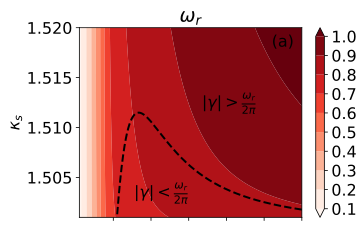

In [232]:
k_grid,kappa_s_grid=np.meshgrid(kls_list,kappa_s_list)
fig = plt.figure(figsize=(5,3.5))
ax1 = plt.subplot(111)
# ax1.set_xlabel('$k\lambda_s$')
ax1.set_ylabel('$\kappa_s$')
plt.xticks(x_ticks1,())

# lvs = [0,0.2,0.4,0.6,0.8,1.0,1.2]
cm1 = ax1.contourf(k_grid,kappa_s_grid,wr_kw_mat,levels=10,cmap='Reds',extend='both')
ax1.contour(k_grid,kappa_s_grid,b_kw_mat_kappas,levels=[-1,0],colors='Black')
# ax1.contourf(k_grid,kappa_s_grid,b_kw_mat_kappas,levels=[-1,0],colors='Black',alpha=0.2)
ax1.text(1.55,1.503,r'$|\gamma|<\frac{\omega_r}{2\pi}$')
ax1.text(3.35,1.512,r'$|\gamma|>\frac{\omega_r}{2\pi}$')
ax1.text(5.2,0.019*0.9+1.501,'(a)')
# plt.clabel(cf1,inline=True,fontsize=8)
fig.colorbar(cm1)
# ax1.axhline(1.5115,linestyle=':')
ax1.set_title("$\omega_r$")

# plt.suptitle("$\kappa_f = \infty$"+"; $n_s = $"+str(n_s)+"; $T = $"+str(T))
# plt.savefig('./figs/3a-wdr-ks.pdf',dpi=600,bbox_inches = 'tight')
plt.show()

### KW波色散关系随$\kappa_f$变化规律

In [204]:
kappa_f_list = np.linspace(8,2,num=800)
kls_list = np.linspace(0.1,6.0,num=800)
x_ticks1 = np.linspace(0,6,num=7)

In [205]:
n_s=0.65
kappa_s = 1.501
kappa_f = kappa_f_list[0]
T = 1
n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
k_list = kls_list/l_s
s0=op.root(lambda w:PDR_2KE(w,k_list[0]),[0.03,-0.1])
print(s0.success,s0.x)

True [ 0.06126555 -0.04980166]


In [206]:
wr_kw_guess = s0.x[0] 
wi_kw_guess = s0.x[1]

wr_kw_mat = []
wi_kw_mat = []
b_kw_mat_kappaf = []

for kappa_f_each in tqdm(kappa_f_list,position=0,leave=True):
    kappa_f = kappa_f_each
    n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()

    wr_kw_list = []
    wi_kw_list = []
    
    for k_each in k_list:
        s_kw = op.root(lambda w:PDR_2KE(w,k_each),[wr_kw_guess,wi_kw_guess])
        if s_kw.success==True:
            wr_kw_guess = round(s_kw.x[0],6)
            wi_kw_guess = round(s_kw.x[1],6)
            if s_kw.x[0] not in wr_kw_list:
                wr_kw_list.append(s_kw.x[0])
                wi_kw_list.append(s_kw.x[1])
        else:
            wr_kw_list.append(np.nan)
            wi_kw_list.append(np.nan)
            

        b_list = np.array(wi_kw_list)/abs(np.array(wr_kw_list)/2/np.pi)
        
    wr_kw_guess = wr_kw_list[0]
    wi_kw_guess = wi_kw_list[0]
    
    wr_kw_mat.append(wr_kw_list)
    wi_kw_mat.append(wi_kw_list)
    b_kw_mat_kappaf.append(b_list)

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [04:13<00:00,  3.15it/s]


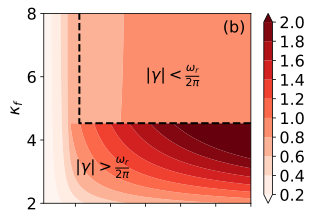

In [220]:
k_grid,kappa_f_grid=np.meshgrid(kls_list,kappa_f_list)
fig = plt.figure(figsize=(4.65,3.5))
lvs = [0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]
cm1 = plt.contourf(k_grid,kappa_f_grid,wr_kw_mat,levels=lvs,cmap='Reds',extend='both')
plt.ylabel('$\kappa_f$')
plt.xticks(x_ticks1,())
plt.contour(k_grid,kappa_f_grid,b_kw_mat_kappaf,levels=[-1,0],colors='Black')
fig.colorbar(cm1)
plt.text(3,5.9,r'$|\gamma|<\frac{\omega_r}{2\pi}$')
plt.text(1.0,3.0,r'$|\gamma|>\frac{\omega_r}{2\pi}$')
plt.text(5.2,6*0.9+2,'(b)')
# plt.axhline(4.52,linestyle=':')

# plt.title("$\kappa_s = $"+str(kappa_s)+"; $n_s = $"+str(n_s)+"; $T = $"+str(T))
# plt.savefig('./figs/3b-wdr-kf.pdf',dpi=600,bbox_inches = 'tight')
plt.show()

### KW波色散关系随$n_s$变化规律

In [203]:
n_s_list = np.linspace(0.1,0.8,num=800)
kls_list = np.linspace(0.1,6.0,num=800)
x_ticks1 = np.linspace(0,6,num=7)
n_ticks1 = np.linspace(0.1,0.8,num=8)

In [191]:
kappa_s = 1.505
kappa_f = 0
n_s=n_s_list[0]
# n_s = 0.1
T = 1
n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
k_list = kls_list/l_s
s0=op.root(lambda w:PDR_2KE(w,k_list[0]),[0.01,-0.002])
print(s0.success,s0.x)

True [ 0.01082843 -0.00362179]


In [192]:
wr_kw_guess = s0.x[0] 
wi_kw_guess = s0.x[1]

wr_kw_mat = []
wi_kw_mat = []
b_kw_mat_ns = []

for n_s_each in tqdm(n_s_list,position=0,leave=True):
    n_s = n_s_each
    n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
    k_list = kls_list/l_s

    wr_kw_list = []
    wi_kw_list = []
    
    for k_each in k_list:
        s_kw = op.root(lambda w:PDR_2KE(w,k_each),[wr_kw_guess,wi_kw_guess])
        if s_kw.success==True:
            wr_kw_guess = round(s_kw.x[0],6)
            wi_kw_guess = round(s_kw.x[1],6)
            if s_kw.x[0] not in wr_kw_list:
                wr_kw_list.append(s_kw.x[0])
                wi_kw_list.append(s_kw.x[1])
        else:
            wr_kw_list.append(np.nan)
            wi_kw_list.append(np.nan)
        b_list = np.array(wi_kw_list)/abs(np.array(wr_kw_list)/2/np.pi)
        
    wr_kw_guess = wr_kw_list[0]
    wi_kw_guess = wi_kw_list[0]
    
    wr_kw_mat.append(wr_kw_list)
    wi_kw_mat.append(wi_kw_list)
    b_kw_mat_ns.append(b_list)

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [04:26<00:00,  3.01it/s]


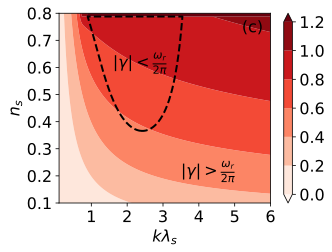

In [194]:
k_grid,n_s_grid=np.meshgrid(kls_list,n_s_list)
fig = plt.figure(figsize=(4.75,3.5))

lvs = [0,0.2,0.4,0.6,0.8,1.0,1.2]
cm1 = plt.contourf(k_grid,n_s_grid,wr_kw_mat,levels=lvs,cmap='Reds',extend='both')
plt.xlabel('$k\lambda_s$')
plt.ylabel('$n_s$')
plt.xticks(x_ticks1)
plt.yticks(n_ticks1)
plt.contour(k_grid,n_s_grid,b_kw_mat_ns,levels=[-1,0],colors='Black')
fig.colorbar(cm1)
plt.text(1.6,0.6,r'$|\gamma|<\frac{\omega_r}{2\pi}$')
plt.text(3.5,0.2,r'$|\gamma|>\frac{\omega_r}{2\pi}$')
plt.text(5.2,0.7*0.9+0.1,'(c)')
# plt.axhline(0.36,linestyle=':')

# plt.title(r"$\kappa_s = $"+str(kappa_s)+"; $T = $"+str(T))
# plt.savefig('./figs/3c-wdr-ns.pdf',dpi=600,bbox_inches = 'tight')
plt.show()

### KW波存在条件：$\gamma < \omega/(2\pi)$
令$b = \gamma/\frac{\omega}{2\pi}$

#### $b_{min}(n_s,\kappa_s)$图

In [9]:
n_s_list = np.linspace(0.1,0.9,num=200)
kappa_s_list = np.linspace(1.501,1.53,num=200)
kls_list = np.linspace(0.1,6.0,num=400)
n_ticks = np.linspace(0.1,0.9,num=9)

In [10]:
n_s=n_s_list[0]
T = 1
kappa_s = kappa_s_list[0]
kappa_f = 0
n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
k_list = kls_list/l_s
s0=op.root(lambda w:PDR_2KE(w,k_list[0]),[0.01,-0.003])
print(s0.success,s0.x)

True [ 0.01036779 -0.00247238]


In [11]:
b_max_mat = []
wr_kw_guess = round(s0.x[0],4)
wi_kw_guess = round(s0.x[1],4)
wr_k0 = 0.0
wi_k0 = 0.0
wr_kappa0 = 0.0
wi_kappa0 = 0.0

for n_s_each in tqdm(n_s_list,position=0,leave=True):
    n_s = n_s_each
    b_max_list = []
    for kappa_s_each in kappa_s_list:
        kappa_s = kappa_s_each
        n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
        k_list = kls_list/l_s
        b_list=np.array([])
        for k_each in k_list:
            s = op.root(lambda w:PDR_2KE(w,k_each),[wr_kw_guess,wi_kw_guess])
            if s.success==True:
                wr_kw_guess = round(s.x[0],6)
                wi_kw_guess = round(s.x[1],6)
                b_list=np.append(b_list,(s.x[1]/abs(s.x[0]/2/np.pi)))
            if k_each == k_list[0]:
                wr_k0 = s.x[0]
                wi_k0 = s.x[1]
                if kappa_s_each == kappa_s_list[0]:
                    wr_kappa0 = wr_k0
                    wi_kappa0 = wi_k0
        b_max_list.append(np.amax(b_list))
        wr_kw_guess = wr_k0
        wi_kw_guess = wi_k0
    b_max_mat.append(b_max_list)
    wr_kw_guess = wr_kappa0
    wi_kw_guess = wi_kappa0

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [2:02:05<00:00, 36.63s/it]


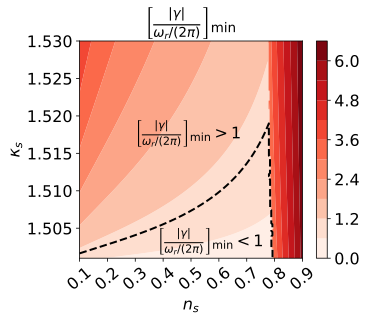

In [39]:
kappa_s_grid,n_s_grid=np.meshgrid(kappa_s_list,n_s_list)
fig = plt.figure(figsize=(5,4))
cm = plt.contourf(n_s_grid,kappa_s_grid,abs(np.array(b_max_mat)),levels=10,cmap='Reds')
plt.contour(n_s_grid,kappa_s_grid,b_max_mat,levels=[-1,0],colors='Black')
plt.title(r'$\left[ \frac{|\gamma|}{\omega_r/(2\pi)}\right]_{\min}$',pad=12)
plt.xlabel('$n_s$')
plt.xticks(n_ticks,rotation=40)
plt.ylabel('$\kappa_s$')
fig.colorbar(cm)
plt.text(0.38,1.5026,r'$\left[ \frac{|\gamma|}{\omega_r/(2\pi)}\right]_{\min}<1$')
plt.text(0.3,1.517,r'$\left[ \frac{|\gamma|}{\omega_r/(2\pi)}\right]_{\min}>1$')
# plt.axvline(0.79,linestyle=':')
# plt.grid()
# plt.savefig('./figs/fig4.pdf',dpi=600,bbox_inches = 'tight')
plt.show()

#### $b_{max}(\kappa_s,\kappa_f)$图

In [36]:
kls_list = np.linspace(0.1,3.0,num=200)
kappa_s_list = np.linspace(1.501,1.53,num=10)
kappa_f_list = np.linspace(10,2,num=20)

In [37]:
T = 1
n_s = 0.7
kappa_s = kappa_s_list[0]
kappa_f = kappa_f_list[0]
n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
k_list = kls_list/l_s
s0=op.root(lambda w:PDR_2KE(w,k_list[0]),[0.0072,-0.016])
print(s0.success,s0.x)

True [ 0.06662224 -0.05702342]


In [38]:
b_max_mat = []
wr_kw_guess = round(s0.x[0],4)
wi_kw_guess = round(s0.x[1],4)
wr_k0 = 0.0
wi_k0 = 0.0
wr_kappa0 = 0.0
wi_kappa0 = 0.0

for kappa_f_each in tqdm(kappa_f_list,position=0,leave=True):
    kappa_f = kappa_f_each
    b_max_list = []
    for kappa_s_each in kappa_s_list:
        kappa_s = kappa_s_each
        n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
        b_list=np.array([])
        for k_each in k_list:
            s = op.root(lambda w:PDR_2KE(w,k_each),[wr_kw_guess,wi_kw_guess])
            if s.success==True:
                wr_kw_guess = round(s.x[0],6)
                wi_kw_guess = round(s.x[1],6)
                b_list=np.append(b_list,(s.x[1]/abs(s.x[0]/2/np.pi)))
            if k_each == k_list[0]:
                wr_k0 = s.x[0]
                wi_k0 = s.x[1]
                if kappa_s_each == kappa_s_list[0]:
                    wr_kappa0 = wr_k0
                    wi_kappa0 = wi_k0
        b_max_list.append(np.amax(b_list))
        wr_kw_guess = wr_k0
        wi_kw_guess = wi_k0
    b_max_mat.append(b_max_list)
    wr_kw_guess = wr_kappa0
    wi_kw_guess = wi_kappa0

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.14it/s]


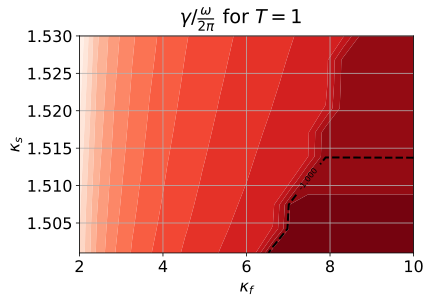

In [40]:
kappa_s_grid,kappa_f_grid=np.meshgrid(kappa_s_list,kappa_f_list)
cm = plt.contourf(kappa_f_grid,kappa_s_grid,b_max_mat,levels=15,cmap='Reds')
cf = plt.contour(kappa_f_grid,kappa_s_grid,b_max_mat,levels=[-1,0],colors='Black')
# cf = plt.contour(kappa_f_grid,kappa_s_grid,b_max_mat,levels=[-1,0],colors='Black')
plt.clabel(cf,inline=True,fontsize=8)
plt.suptitle(r'$\gamma/\frac{\omega}{2\pi}$' + r' for $T=$'+str(T))
plt.xlabel('$\kappa_f$')
plt.ylabel('$\kappa_s$')
plt.grid()
plt.show()

## 模拟验证

### 模拟参数设定

In [9]:
T = 1
n_s = 0.75
kappa_s = 1.501
kappa_f = 20
n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
PrintParas()

kls = 3.5
k = kls/l_s
L = 2*np.pi/k

vmax = 10 # 速度最大值
nx = 200
nv = 4000
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)
dt = 0.005
max_steps  = 8000
data_steps = max_steps
data_num = int(max_steps/data_steps)+1
d = 1e-3
linear_time = 2*np.pi/np.sqrt(d)

path = '../data/'
print(data_num)
print('k=',k)
print('limited time=',2*np.pi/k/dv)
print('real time = ', max_steps*dt)
print('linear time=',linear_time)

+-----+------+-------+-------+--------+----------+
| T=1 |  n   | kappa |   wp  | theta  | lambda_D |
+-----+------+-------+-------+--------+----------+
|  s  | 0.75 | 1.501 | 0.866 | 0.0365 |  1.1547  |
|  f  | 0.25 |   -   |  0.5  | 1.3601 |   2.0    |
+-----+------+-------+-------+--------+----------+
2
k= 3.0310889132455356
limited time= 414.47906614700776
real time =  40.0
linear time= 198.69176531592203


In [10]:
kls_idx = int((kls-0.1)/(kls_list[1]-kls_list[0]))-1
s_lw_sim=op.root(lambda w:PDR_2KE(w,k),[wr_lw_list[kls_idx],wi_lw_list[kls_idx]])
s_kw_sim=op.root(lambda w:PDR_2KE(w,k),[wr_kw_list[kls_idx],wi_kw_list[kls_idx]])
print(s_lw_sim.success,s_lw_sim.x)
print(s_kw_sim.success,s_kw_sim.x)
print('damping time=',-1/s_kw_sim.x[1])

False [nan nan]
True [ 0.89374504 -0.04422119]
damping time= 22.613592022948698


### KW条件检验
- $\gamma_{KW} < \gamma_{LW}^{hot}$

In [11]:
print('r_kw = ',round(abs(s_kw_sim.x[1]),6))
print('r_lw = ',round(abs(s_lw_sim.x[1]),6))

r_kw =  0.044221
r_lw =  nan


- $k\lambda_h \le 1$

In [12]:
print('k*l_D_f = ',round(k*l_f,6))

k*l_D_f =  6.062178


- $\gamma_{KW} < \omega_r/(2\pi)$

In [13]:
print('r_eaw   = ',round(abs(s_kw_sim.x[1]),6))
print('wr/2/pi = ',round(s_kw_sim.x[0]/2/np.pi,6))

r_eaw   =  0.044221
wr/2/pi =  0.142244


### 模拟结果

In [14]:
dataet = np.loadtxt(os.path.join(path,"tot_energy"))[0:max_steps]
dataep = np.loadtxt(os.path.join(path,"pot_energy"))[0:max_steps]
dataek = np.loadtxt(os.path.join(path,"kin_energy"))[0:max_steps]

t = np.linspace(0, max_steps, max_steps)

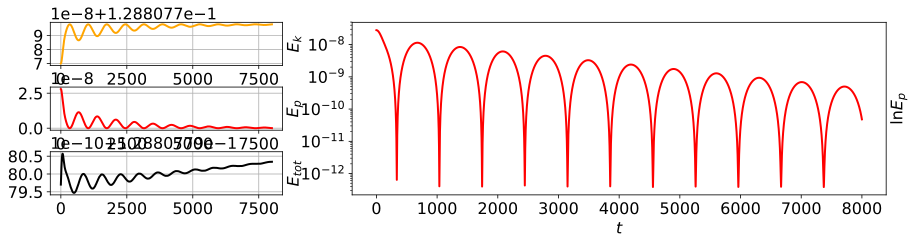

In [15]:
fig = plt.figure(figsize=(15, 3))

ax1 = plt.subplot2grid((3, 3), (0, 0))
ax1.plot(t, dataek, color='orange')
ax1.grid()
ax1.set_ylabel(r'$E_k$')
ax1.yaxis.set_label_position("right")

ax2 = plt.subplot2grid((3, 3), (1, 0))
ax2.plot(t, dataep, color='r')
ax2.grid()
ax2.set_ylabel(r'$E_p$')
ax2.yaxis.set_label_position("right")

ax3 = plt.subplot2grid((3, 3), (2, 0))
ax3.plot(t, dataet, color='black')
ax3.grid()
ax3.set_ylabel(r'$E_{tot}$')
ax3.yaxis.set_label_position("right")

axl2 = plt.subplot2grid((3, 3), (0, 1),colspan=2, rowspan=3)
axl2.plot(t, dataep, color='r')
axl2.set_ylabel(r'$\ln E_p$')
axl2.set_yscale('log')
axl2.yaxis.set_label_position("right")

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.3)
plt.xlabel(r'$t$')
plt.show()

In [16]:
progesses = np.arange(0,data_num,1)

f = []
phi = []

for progess in progesses:
    f_temp = np.loadtxt(os.path.join(path,"data"+str(progess)))
    f.append(f_temp)
    phi_temp = np.loadtxt(os.path.join(path,"phi"+str(progess)))
    phi.append(phi_temp)

In [17]:
fx0 = np.sum(f[0],axis=1)*dv
fv0 = np.sum(f[0],axis=0)*dx/L
fx = np.sum(f[data_num-1],axis=1)*dv
fv = np.sum(f[data_num-1],axis=0)*dx/L

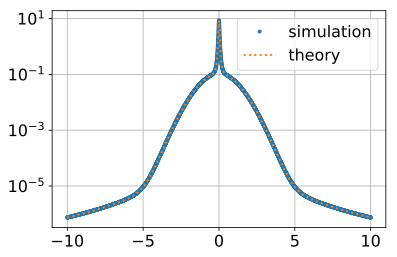

In [18]:
plt.plot(v,fv0,'.',label='simulation')
plt.plot(v,fk(v),':',label='theory')
plt.grid()
plt.yscale('log')
plt.legend()
plt.show()

$$ E_p \propto E^2 \propto \left( e^{i \omega_r t+\omega_i t} \right)^2 = e^{i 2\omega_r t+2\omega_i t} $$

In [19]:
def line(p, x):
    k, b = p
    return k*x+b

def errorWithLine(p, x, y):
    r = line(p, x)-y
    return r

def period(x):
    return (x[1]-x[0])/1.

def errPercent(a, b):
    r = abs((a-b)/b)
    return r

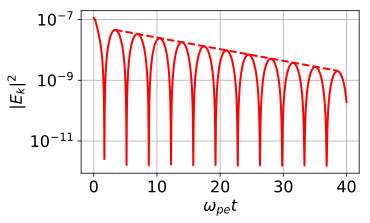

In [23]:
t_ticks = np.array([0,2000,4000,6000,8000])
wt_ticks = np.array([0,10,20,30,40])
indexes, _ = scipy.signal.find_peaks(dataep, distance=5)
xep = indexes[0:11:1]
yep = np.log(dataep[xep])
para, nouse = op.leastsq(errorWithLine, [-1, 1], args=(xep, yep))
per_sim = period(xep) * dt
wr_sim = 2*np.pi/per_sim/2
wi_sim = para[0]/dt/2
theo_yep = np.exp(-2j*(s_kw_sim.x[0]+1j*s_kw_sim.x[1])*xep*dt).real

fig = plt.figure(figsize=(5,3))
plt.plot(t,4*dataep,color='red')
# plt.plot(xep,np.exp(line(para,xep)), '-',color='green')
plt.plot(xep,4*theo_yep/theo_yep[0]*dataep[xep[0]], '--',color='red')
plt.xticks(t_ticks,wt_ticks)
plt.xlabel(r'$\omega_{pe}t$')
plt.ylabel(r'$|E_k|^2$')
plt.yscale('log')
plt.grid()
# plt.savefig('./figs/fig8.pdf',dpi=600,bbox_inches = 'tight')
plt.show()

In [24]:
wr0_err = abs(wr_sim-s_kw_sim.x[0])/s_kw_sim.x[0]*100
wr1_err = abs(wr_sim-s_lw_sim.x[0])/s_lw_sim.x[0]*100
wi0_err = abs(abs(wi_sim)-abs(s_kw_sim.x[1]))/abs(s_kw_sim.x[1])*100
wi1_err = abs(abs(wi_sim)-abs(s_lw_sim.x[1]))/abs(s_lw_sim.x[1])*100
com_table = PrettyTable(['EAW: k='+str(k),'wr','wi'])
com_table.add_row(['Theory0',round(s_kw_sim.x[0],6),round(abs(s_kw_sim.x[1]),6)])
com_table.add_row(['Theory1',round(s_lw_sim.x[0],6),round(abs(s_lw_sim.x[1]),6)])
com_table.add_row(['Simulation',round(wr_sim,6),round(abs(wi_sim),6)])
com_table.add_row(['Error0(%)',round(wr0_err,6),round(abs(wi0_err),6)])
com_table.add_row(['Error1(%)',round(wr1_err,6),round(abs(wi1_err),6)])
print(com_table)

+---------------------------+----------+----------+
| EAW: k=3.0310889132455356 |    wr    |    wi    |
+---------------------------+----------+----------+
|          Theory0          | 0.893745 | 0.044221 |
|          Theory1          |   nan    |   nan    |
|         Simulation        | 0.893767 | 0.044518 |
|         Error0(%)         | 0.002509 | 0.671915 |
|         Error1(%)         |   nan    |   nan    |
+---------------------------+----------+----------+


In [25]:
print(s_kw_sim.x)

[ 0.89374504 -0.04422119]


In [64]:
kls_sim1 = np.array([1.0,1.5,2.0,2.5,3.0,3.5,4.0])#ks=1.501 kf=20 ns=0.75

In [22]:
wr_sim1 = np.array([0.8203,0.8344,0.8560,0.8715,0.8837,0.8938,0.9028])
wi_sim1 = np.array([-0.1167,-0.04995,-0.03485,-0.03339,-0.0375,-0.04449,-0.05324])

In [23]:
kls1_strong = kls_list[b_kw<-1]
wr_theo1_strong = wr_kw_list[b_kw<-1]
wi_theo1_strong = wi_kw_list[b_kw<-1]

kls1_weak = kls_list[b_kw>-1]
wr_theo1_weak = wr_kw_list[b_kw>-1]
wi_theo1_weak = wi_kw_list[b_kw>-1]

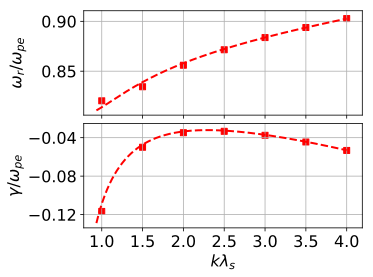

In [25]:
fig = plt.figure(figsize=(5,4))

ax1 = plt.subplot(211)
plt.xticks(x_ticks,())
ax1.set_ylabel(r'$\omega_r/\omega_{pe}$',labelpad=15)
ax1.grid()
ax2 = plt.subplot(212)
plt.xticks(x_ticks)
plt.yticks([-0.04,-0.08,-0.12])
ax2.set_xlabel(r'$k\lambda_s$')
ax2.set_ylabel(r'$\gamma/\omega_{pe}$')
ax2.grid()

ax1.plot(kls1_weak,wr_theo1_weak,'--',color='red')
ax1.scatter(kls_sim1,wr_sim1,marker='s',color='red')

ax2.plot(kls1_weak,wi_theo1_weak,'--',color='red')
ax2.scatter(kls_sim1,wi_sim1,marker='s',color='red')

plt.subplots_adjust(hspace = 0.08,wspace=0.0)
# plt.savefig('./figs/fig9.pdf',dpi=600,bbox_inches = 'tight')
plt.show()